# 離散コサイン変換 (discrete cosine transform)

信号処理に使われる変換で、
空間あるいは時間領域から周波数領域に変換するもの。

実信号の場合、フーリエ変換よりも使い勝手がよい。

1次元の場合、N点のサンプルをN次元のベクトルとみなすと、
DCTはN次元実ベクトル空間$\mathbb{R}^N$上の座標変換とみなすことができる。

## 線形代数の復習

(i, j)成分とは、i行j列の成分を表す。
numpyでは`M[i]`, `M[i, :]`がi行、`M[:,j]`がj列のベクトルを表す。
ただし、numpy.ndarrayは、行ベクトルと列ベクトルを区別しない。

- 直交：2つのベクトルについて、内積が0になること。
- 正規直交系(orthonormal system)：互いに直交し、大きさが1のベクトルの集まり。Gram-Schmidtの直交化法で一次独立なベクトルたちから構成できる。
- 直交行列(orthogonal matrix)：$M^T = M^{-1}$を満たす正方行列。内積を保つ線形変換であること、各列あるいは行を並べたベクトルたちが正規直交基底をなすことと同値。（正規化されていない単なる直交基底を並べてできる行列には名前はない（$M^{T}M$が対角行列になるだけ））

## いろいろな表式

直交系のとり方にはいくつかの種類があり、DCT-I～IVが一般的である。
ここでの表式は、正規直交系をなすようにnormalizeしていないものであるが、
正規化することで係数行列が直交行列になるように構成できる。

それぞれのDCTは周期信号の境界条件の設定を変えて導出されたものとして理解できる。
参考：http://www-math.mit.edu/~gs/papers/dct.pdf

## DCT-I
$$
X_k = \frac{1}{2} (x_0 + (-1)^k x_{N-1}) 
 + \sum_{n=1}^{N-2} x_n \cos \left[\frac{\pi}{N-1} n k \right] \quad \quad k = 0, \dots, N-1.
$$

## DCT-II
$$
X_k =
 \sum_{n=0}^{N-1} x_n \cos \left[\frac{\pi}{N} \left(n+\frac{1}{2}\right) k \right] \quad \quad k = 0, \dots, N-1.
$$

## DCT-III
$$
X_k = \frac{1}{2} x_0 +
 \sum_{n=1}^{N-1} x_n \cos \left[\frac{\pi}{N} n \left(k+\frac{1}{2}\right) \right] \quad \quad k = 0, \dots, N-1.
$$

## DCT-IV
$$
X_k =
 \sum_{n=0}^{N-1} x_n \cos \left[\frac{\pi}{N} \left(n+\frac{1}{2}\right) \left(k+\frac{1}{2}\right) \right] \quad \quad k = 0, \dots, N-1.
$$

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def check_orthogonality(M):
    '''calculate the norm and of '''
    norm = {}
    dot = {}
    n, m = M.shape
    if n != m:
        raise Exception
    for i in range(n):
        norm[i] = np.linalg.norm(M[i,:])
        for j in range(i+1, n):
            dot[(i, j)] = np.dot(M[i,:], M[j,:])
    return (norm, dot)

In [128]:
def dct_i(N, normalize=True):
    res = np.zeros((N,N))
    res[:,0] = 1/2
    for i in range(1, N-1):
        for j in range(N):
            res[j,i] = np.cos(np.pi/(N-1)*j*i)
    for j in range(N):
        res[j,N-1] = (-1)**j / 2
    # apply scaling to make the matrix orthogononal
    if normalize:
        res[:,0] *= np.sqrt(2)
        res[:,N-1] *= np.sqrt(2)
        res[0,:] /= np.sqrt(2)
        res[N-1,:] /= np.sqrt(2)
        res *= np.sqrt(2 / (N - 1))
    return res


def dct_ii(N, normalize=True):
    res = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            res[j,i] = np.cos(np.pi/N*(i+1/2)*j)
    # apply scaling to make the matrix orthogonal
    if normalize:
        res[0, :] /= np.sqrt(2)
        res *= np.sqrt(2/N)
    return res

def dct_iii(N, normalize=True):
    res = np.zeros((N, N))
    res[:,0] = 1/2
    for i in range(1, N):
        for j in range(N):
            res[j,i] = np.cos(np.pi/N*i*(j+1/2))
    # apply scaling to make the matrix orthogonal
    if normalize:
        res[:, 0] *= np.sqrt(2)
        res *= np.sqrt(2/N)
    return res

def dct_iv(N, normalize=True):
    res = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            res[j,i] = np.cos(np.pi/N*(i+1/2)*(j+1/2))
    if normalize:
        res *= np.sqrt(2/N)
    return res

In [133]:
def plot_bases(M, *r):
    mx = np.max(M)
    dim = M.shape[0]
    lim = [-mx, mx]
    if len(r) == 0:
        r = [dim]
    plt.rcParams['figure.figsize'] = [5, 10]
    fig = plt.figure()
    num = len(list(range(*r)))
    prev = None
    for i, no in enumerate(range(*r)):
        if prev is None:
            ax = fig.add_subplot(num, 1, i+1)
            prev = ax
        else:
            ax = fig.add_subplot(num, 1, i+1, sharex=prev, sharey=prev)
        #ax.ylim(lim)
        #print(np.arange(dim), M[no,:])
        ax.bar(np.arange(dim), M[no,:], width=1, linewidth=0)
    return fig


def plot_dct_kernels(dim, *r):
    if len(r) == 0:
        r = [dim]
    num = len(list(range(*r)))
    plt.rcParams['figure.figsize'] = [16, num*2]
    fig = plt.figure()
    prev = None
    dcts = {
        1: dct_i,
        2: dct_ii,
        3: dct_iii,
        4: dct_iv
    }
    for j in range(1,5):
        dct = dcts[j]
        M = dct(dim, normalize=False)
        for i, no in enumerate(range(*r)):
            if prev is None:
                ax = fig.add_subplot(num, 4, 4*i+j)
                prev = ax
            else:
                ax = fig.add_subplot(num, 4, 4*i+j, sharex=prev, sharey=prev)
            ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
            ax.bar(np.arange(dim), M[no,:], color='#1E7F00', width=1, linewidth=0)
            if i == 0:
                ax.title.set_text('DCT-{}'.format(j))
    fig.tight_layout()
    return fig

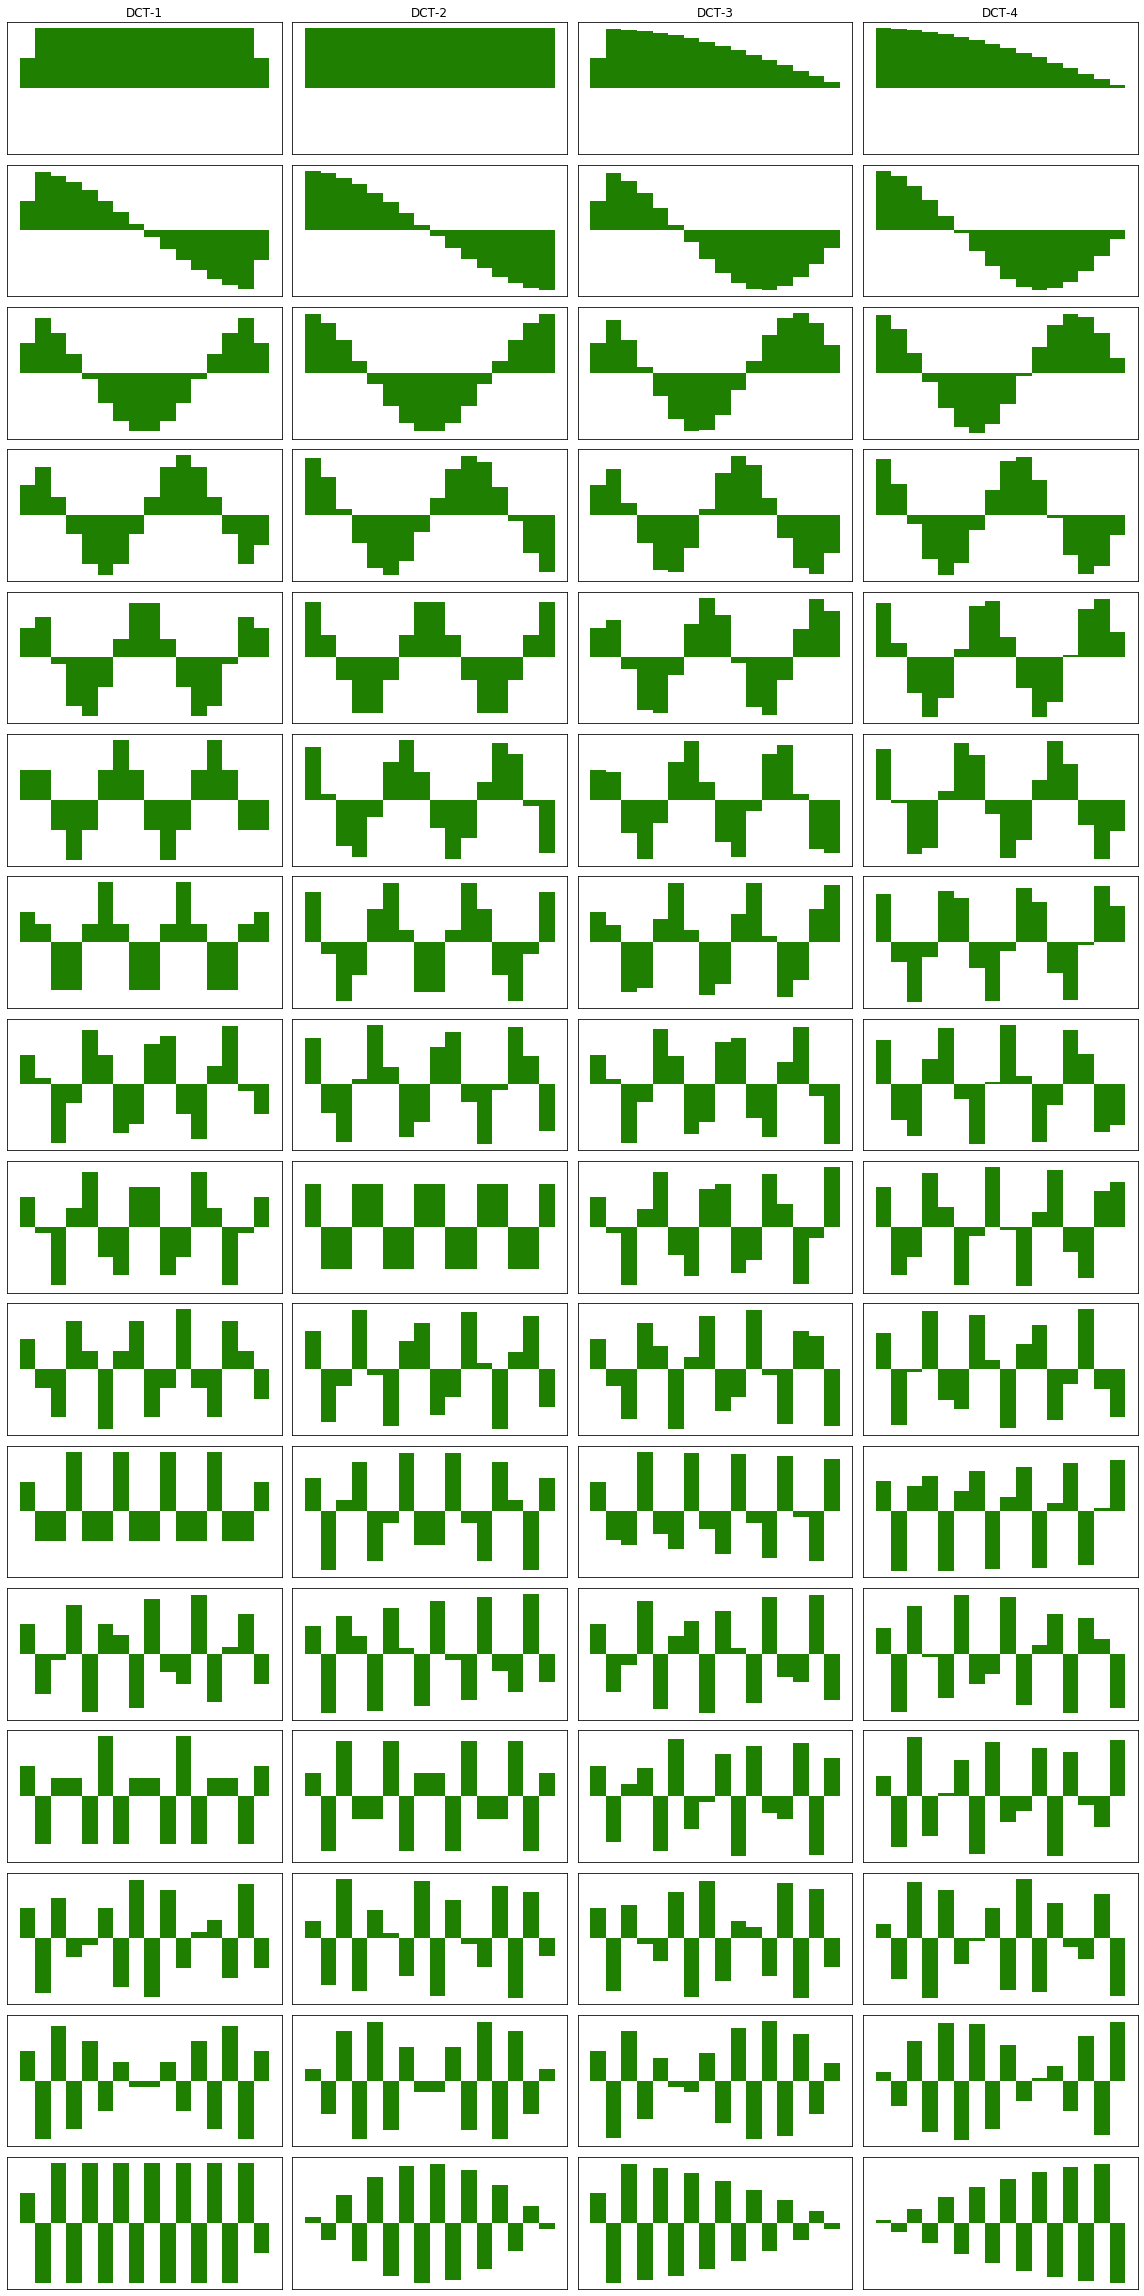

In [136]:
f = plot_dct_kernels(16)
f.savefig('test.png')